# **Unraveling High-Dimensional Data with Manifold Learning**
---
---

This notebook presents a study of **nonlinear dimensionality reduction** and **manifold learning** techniques across both **synthetic datasets** that explicitly satisfy the manifold hypothesis and **real-world datasets** that may only approximately exhibit low-dimensional local structure. We compare classical and modern manifold learning algorithms with respect to:

- **Geometric fidelity** (local neighborhood preservation).
- **Clustering and separability quality** in low-dimensional embeddings.
- **Computational efficiency**.

For each dataset, we compute and visualize two-dimensional embeddings using:

- **t-Distributed Stochastic Neighbor Embedding (t-SNE)**
- **Isomap**
- **Spectral Embedding (Laplacian Eigenmaps)**
- **Locally Linear Embedding (LLE)**
- **Uniform Manifold Approximation & Projection (UMAP)**

Each embedding is plotted alongside the **original data** (in 3D when available, or through PCA otherwise) for direct visual comparison.

---
## Evaluation Metrics
---
We evaluate embeddings using **only built-in, rigorously defined metrics**:

- **Trustworthiness** — measures preservation of local neighborhoods from high- to low-dimensional space  
- **Silhouette Score** — evaluates cluster separation and cohesion  
- **Calinski–Harabasz Index** — ratio of between-cluster to within-cluster dispersion  
- **Davies–Bouldin Index** — average similarity between clusters (lower is better)  
- **k-Nearest Neighbor Classification Accuracy** — downstream task performance  
- **Runtime (seconds)** — empirical algorithmic efficiency

Metrics are displayed directly on each embedding plot and aggregated across datasets for global comparison.

In [ ]:
!pip -q install umap-learn

import os, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import (
    load_digits, load_iris, load_wine, load_breast_cancer,
    make_swiss_roll, make_s_curve, make_blobs
)
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import (
    TSNE,
    Isomap,
    SpectralEmbedding,
    LocallyLinearEmbedding,
    trustworthiness
)
import umap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from scipy.sparse import SparseEfficiencyWarning

In [ ]:
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

warnings.filterwarnings(
    "ignore",
    message="The number of connected components of the neighbors graph is .*",
    category=UserWarning,
    module="sklearn.manifold._isomap",
)

warnings.filterwarnings(
    "ignore",
    message="Graph is not fully connected, spectral embedding may not work as expected.*",
    category=UserWarning,
    module="sklearn.manifold._spectral_embedding",
)

warnings.filterwarnings(
    "ignore",
    message="n_jobs value .* overridden to .* by setting random_state.*",
    category=UserWarning,
    module="umap.umap_",
)

In [ ]:
def ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

def discretize_labels(y: np.ndarray, n_bins: int = 10) -> np.ndarray:
    """ORIGINAL: discretize continuous labels into quantile bins."""
    if np.issubdtype(y.dtype, np.integer):
        return y
    bins = np.quantile(y, np.linspace(0, 1, n_bins + 1))
    bins = np.unique(bins)
    return np.digitize(y, bins[1:-1]) if len(bins) > 2 else np.zeros_like(y, dtype=int)

In [ ]:
def plot_accuracy_bar(accuracy_table: dict):
    """
    ORIGINAL: Plot bar chart of KNN classification accuracy by dataset and algorithm.
    """

    acc_df = pd.DataFrame(accuracy_table).T
    acc_df = acc_df[sorted(acc_df.columns)]
    plt.figure(figsize=(10, 5))
    bar_width = 0.15
    x = np.arange(len(acc_df))
    for i, method in enumerate(acc_df.columns):
        plt.bar(x + i * bar_width, acc_df[method], width=bar_width, label=method)
    plt.xticks(
        x + bar_width * (len(acc_df.columns) - 1) / 2,
        acc_df.index,
        rotation=45,
    )
    plt.ylim(0, 1.05)
    plt.ylabel("Accuracy")
    plt.title("Classification accuracy of embeddings by dataset and algorithm")
    plt.legend()
    plt.tight_layout()
    return plt.gcf()

# Mathematical Foundations
---
---

## Manifolds
---

A **manifold** is a topological space $\mathcal{M}=(X,\tau)$ that is

1. **Hausdorff**: for each $x,y\in X$ with $x\not=y$, there exists open sets $U_x, U_y$ such that $U_x\cap U_y=\phi.$

2. **Second-Countable**: the topology $\tau$ admits a countable basis.

3. **Locally Euclidean of Dimension $n$**: for each $x\in X$, there exists some open neighborhood $U_x\in\tau$ and a homeomorphism $\varphi: U\mapsto U'\subset\mathbb{R}^n$. Such a homeomorphism $\varphi$ is called a chart of $\mathcal{M}$.





### $C^k$-Diffeomorphisms & Atlases

Given two charts $(U,\varphi)$ and $(V,\psi)$ with $U\cap V\not=\phi$, the **transition map** is given by the map $\omega_{\varphi,\psi}:\psi\circ\varphi^{-1}:\varphi(U\cap V)\mapsto\psi(U\cap V)$. A **$C^k$-diffeomorphism** requires that

1. $\omega$ is bijective.
2. $\omega\in C^k(\varphi[U\cap V])$.
3. $\omega^{-1}\in C^k(\psi[U\cap V])$.

Two charts $(U,\varphi), (V,\psi)$ are said to be **$C^k$-smoothly compatible** if the transition map $\omega_{\varphi,\psi}$ is a $C^k$-diffeomorphism.

An **atlas** $\mathcal{A}$ on $\mathcal{M}$ is an indexed family collection of charts that cover $\mathcal{M}$. An atlas $\mathcal{A}=\{(U_i,\varphi_i)_{i\in I}\}$ is a **$C^k$-atlas** if any two charts in $\mathcal{A}$ are $C^k$-smoothly compatible. A **maximal $C^k$-atlas** $\mathcal{A}$ satisfies:

1. $\mathcal{A}$ is a $C^k$-atlas.
2. For any other $C^k$-atlas $\mathcal{B}$, $\mathcal{A}\not\subseteq\mathcal{B}$.

### Smooth Structures & Embeddings

An $n$-dimensional **$C^k$-smooth manifold** is a manifold $\mathcal{M}$ that admits a maximal $C^k$-atlas. Let $\mathcal{M},\mathcal{N}$ be $C^{\infty}$-smooth manifolds. A function $f:\mathcal{M}\mapsto\mathcal{N}$ is said to be $C^{\infty}$-smooth if $f$ is $k$-times differentiable at $p\in\mathcal{M}$ for each $p\in\mathcal{M}$ and $k\in\mathbb{N}$. Then we can consider an embedding as a $C^{\infty}$-smooth map between $\Psi:\mathcal{M}\mapsto{N}$ whose inverse $\Psi^{-1}:\Psi(M)\mapsto\mathcal{M}$ exists and is also $C^{\infty}$-smooth.

The algorithms implemented below can be seen as embedding $\Psi:\mathcal{M}\mapsto\mathbb{R}^m$.

### Manifold Learning


In [ ]:
def run_embedding_methods(X: np.ndarray, y: np.ndarray) -> tuple:
    """
    Fit manifold embeddings and compute metrics.
    FIX: Increase neighbor counts for Isomap, Spectral, and LLE to avoid disconnected graphs.
    FIX: Remove random_state for UMAP to eliminate n_jobs override warning.
    """
    n_samples = X.shape[0]
    # Increase neighbors for graph-based methods to ensure connectivity
    n_neighbors_graph = min(50, n_samples - 1)

    methods = {
        "t-SNE": TSNE(n_components=2, perplexity=30, random_state=42),
        "Isomap": Isomap(n_neighbors=n_neighbors_graph, n_components=2),
        "Spectral": SpectralEmbedding(
            n_components=2,
            n_neighbors=n_neighbors_graph,
            random_state=42,
        ),
        "LLE": LocallyLinearEmbedding(
            n_neighbors=n_neighbors_graph,
            n_components=2,
            method="standard",
            random_state=42,
        ),
    }

    methods["UMAP"] = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="euclidean",
        random_state=42,
    )

    embeddings = {}
    metrics_dict = {}
    y_disc = discretize_labels(y)
    for name, model in methods.items():
        t0 = time.perf_counter()
        Z = model.fit_transform(X)
        runtime = time.perf_counter() - t0
        m = {
            "trustworthiness": float(trustworthiness(X, Z, n_neighbors=15)),
            "silhouette": float(silhouette_score(Z, y_disc)),
            "calinski_harabasz": float(calinski_harabasz_score(Z, y_disc)),
            "davies_bouldin": float(davies_bouldin_score(Z, y_disc)),
            "runtime_sec": runtime,
        }
        # ORIGINAL: compute KNN classification accuracy using discretized labels
        X_train, X_test, y_train, y_test = train_test_split(
            Z, y_disc, test_size=0.3, random_state=42, stratify=y_disc
        )
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        m["accuracy"] = float(knn.score(X_test, y_test))

        embeddings[name] = Z
        metrics_dict[name] = m

    return embeddings, metrics_dict

For metrics and model evaluation, we primarily focus on trustworthiness, $T(k)$; that is, the extent to which local structure of the original data is retained, where $T(k)\in[0,1]$ for each $k\in\mathbb{N}$. It is defined by $$T(k)=1-\frac{2}{nk(2n-3k-1)}\sum_{i=1}^{n}\sum_{j\in \mathcal{N}_i^{(k)}}max(0, (r(i,j)-k)).$$


### Latent Neighborhood Recoverability (LNR)

For synthetic datasets with known latent parameters (such as the Swiss roll or S-curve), we evaluate embeddings using Latent Neighborhood Recoverability (LNR). LNR measures how well an unsupervised embedding preserves local neighborhoods of an underlying latent coordinate.

Assume each data point $x_i \in \mathbb{R}^D$ is generated from a continuous latent parameter $\theta_i \in \Lambda$ via a smooth map $x_i = g(\theta_i)$. A manifold learning algorithm computes an embedding $z_i = F(x_i) \in \mathbb{R}^m$ without access to the latent parameters.

Because $\theta_i$ is continuous, we discretize it into $K$ equal-frequency bins using empirical quantiles. This produces a coarse latent label $y_i \in {1,\dots,K}$, where each label corresponds to a contiguous region of the latent manifold and contains approximately the same number of samples.

To quantify neighborhood preservation, we train a $k$-nearest-neighbor (k-NN) classifier on the embedded points $(z_i, y_i)$ and evaluate its test accuracy. We define LNR as the probability that the classifier correctly predicts the latent bin label from the embedding, i.e. $\mathrm{LNR}(F;K,k) = \mathbb{P}(g(z_i) = y_i)$, or equivalently its empirical accuracy on held-out data. Chance performance is $1/K$.

High LNR indicates that points close in the embedding tend to originate from the same latent region, consistent with preservation of local manifold structure. Importantly, the latent labels are used only for evaluation and do not supervise the embedding.

In [ ]:
def plot_dataset_and_embeddings(
    X: np.ndarray,
    y: np.ndarray,
    embeddings: dict,
    metrics_dict: dict,
    dataset_name: str,
):
    """
    ORIGINAL: Plot the original 3D/PCA geometry and each 2D embedding with metrics.
    """
    n_methods = len(embeddings)
    fig = plt.figure(figsize=(5 * (n_methods + 1), 5))

    ax0 = fig.add_subplot(1, n_methods + 1, 1, projection="3d")
    if X.shape[1] > 3:
        X_plot = PCA(n_components=3, random_state=0).fit_transform(X)
    else:
        X_plot = X
    ax0.scatter(
        X_plot[:, 0],
        X_plot[:, 1],
        X_plot[:, 2],
        c=y,
        cmap="Spectral",
        s=8,
        alpha=0.85,
    )
    ax0.set_title(f"{dataset_name}: original")
    ax0.set_xlabel("X")
    ax0.set_ylabel("Y")
    ax0.set_zlabel("Z")

    for idx, (name, Z) in enumerate(embeddings.items(), start=2):
        ax = fig.add_subplot(1, n_methods + 1, idx)
        ax.scatter(
            Z[:, 0],
            Z[:, 1],
            c=y,
            cmap="Spectral",
            s=8,
            alpha=0.85,
        )
        m = metrics_dict[name]
        ax.set_title(
            f"{name}\n"
            f"T={m['trustworthiness']:.2f}, SIL={m['silhouette']:.2f}, "
            f"CH={m['calinski_harabasz']:.1f}, DB={m['davies_bouldin']:.2f}\n"
            f"Time={m['runtime_sec']:.2f}s, Acc={m['accuracy']:.2f}"
        )
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")

    plt.tight_layout()
    return fig


=== Dataset: digits | n=1797, d=64 ===


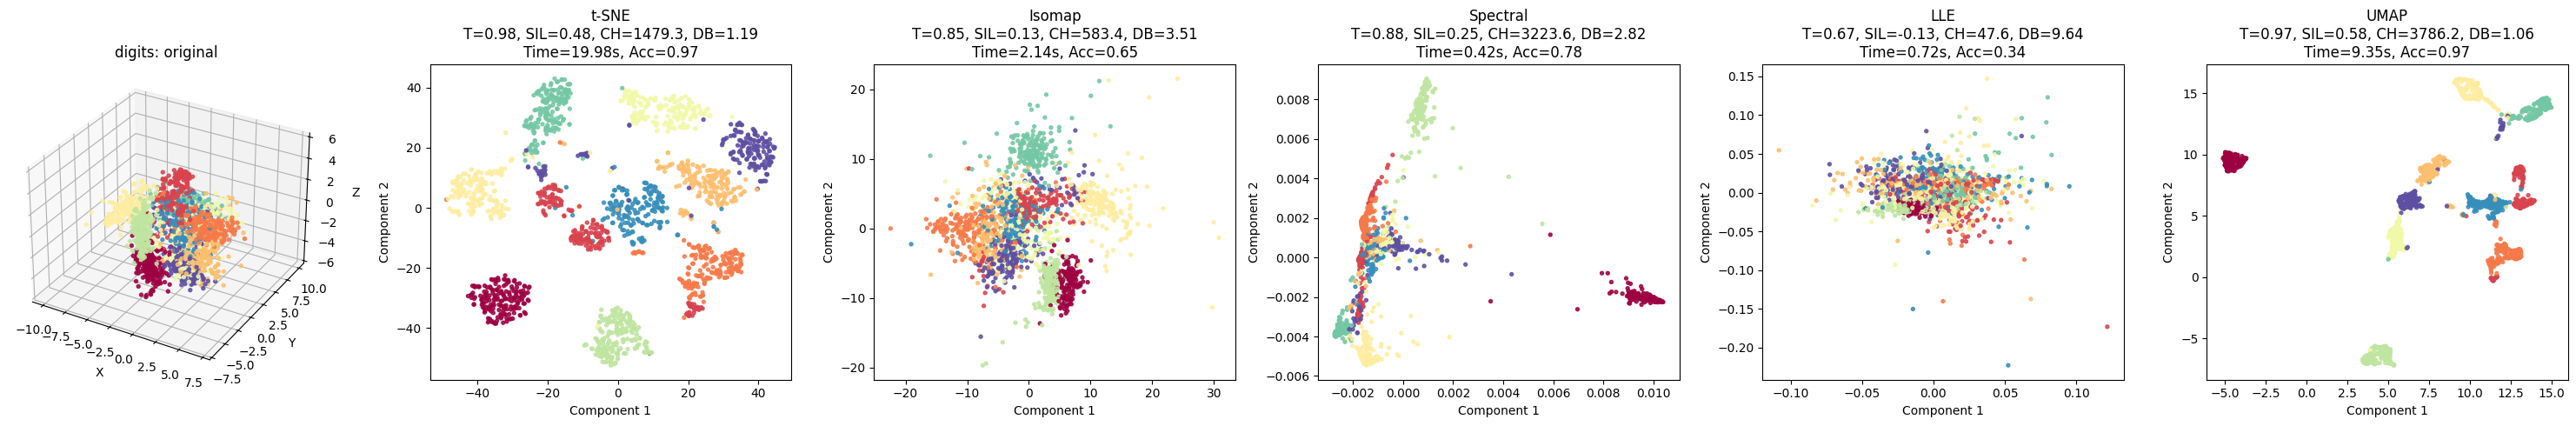

  t-SNE: metrics={'trustworthiness': 0.981676985965795, 'silhouette': 0.48481008410453796, 'calinski_harabasz': 1479.3282470703125, 'davies_bouldin': 1.1876292172694312, 'runtime_sec': 19.98098412200001, 'accuracy': 0.9703703703703703}
  Isomap: metrics={'trustworthiness': 0.8476004832472677, 'silhouette': 0.13127036478944573, 'calinski_harabasz': 583.4210184720172, 'davies_bouldin': 3.5070994529531037, 'runtime_sec': 2.139025705999984, 'accuracy': 0.6462962962962963}
  Spectral: metrics={'trustworthiness': 0.8808659971722046, 'silhouette': 0.25082093662116267, 'calinski_harabasz': 3223.557104766405, 'davies_bouldin': 2.8231386380401204, 'runtime_sec': 0.41637290299999563, 'accuracy': 0.7777777777777778}
  LLE: metrics={'trustworthiness': 0.6662733015504357, 'silhouette': -0.13336208704194488, 'calinski_harabasz': 47.60939901321863, 'davies_bouldin': 9.636127229558525, 'runtime_sec': 0.7248191250000104, 'accuracy': 0.34444444444444444}
  UMAP: metrics={'trustworthiness': 0.972169637608

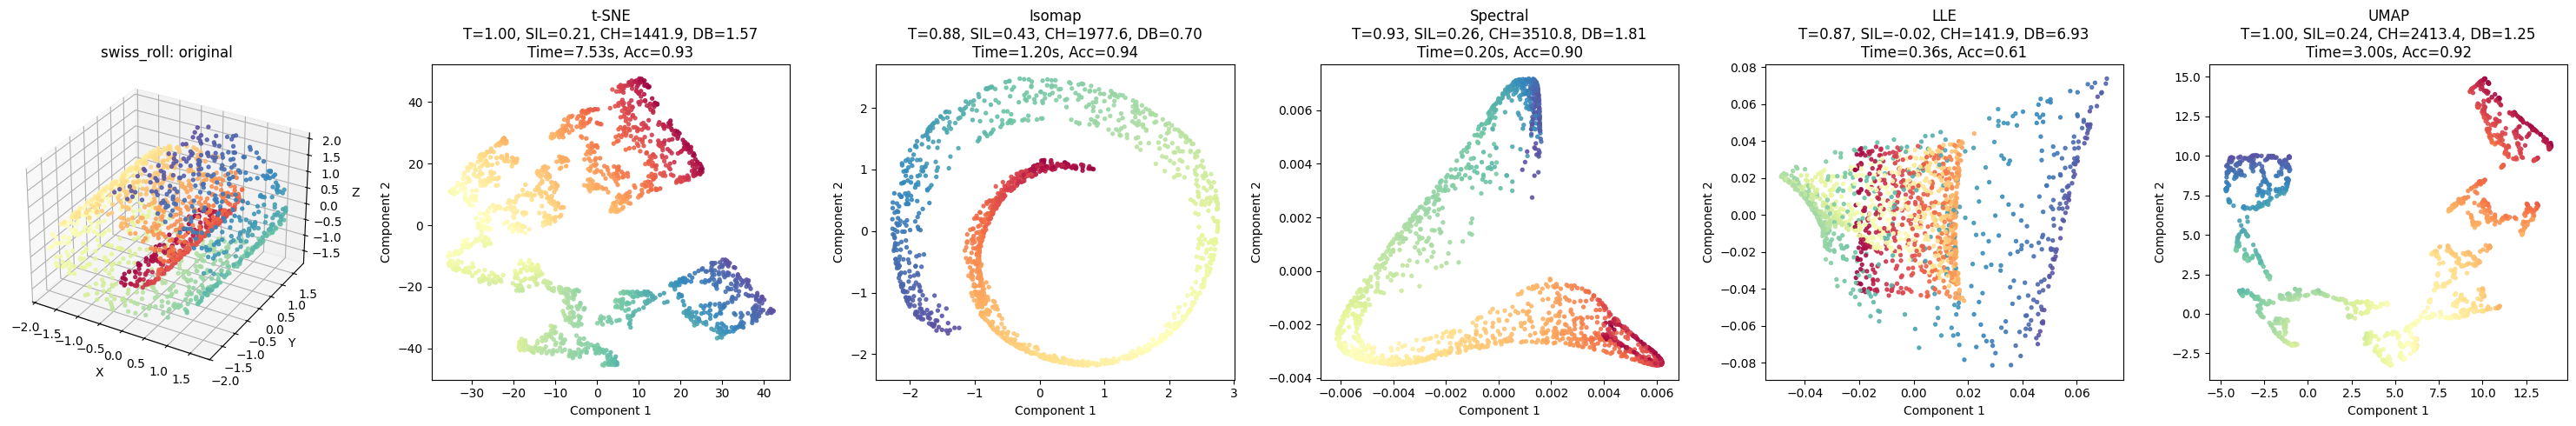

  t-SNE: metrics={'trustworthiness': 0.9993912585571353, 'silhouette': 0.2140105813741684, 'calinski_harabasz': 1441.904541015625, 'davies_bouldin': 1.5729565709968711, 'runtime_sec': 7.5282761229999835, 'accuracy': 0.9288888888888889}
  Isomap: metrics={'trustworthiness': 0.8818653727525765, 'silhouette': 0.4323788580555203, 'calinski_harabasz': 1977.6354041883449, 'davies_bouldin': 0.6954416001426399, 'runtime_sec': 1.1956579589999876, 'accuracy': 0.9444444444444444}
  Spectral: metrics={'trustworthiness': 0.9254600165500639, 'silhouette': 0.26407149647303363, 'calinski_harabasz': 3510.7796220023174, 'davies_bouldin': 1.8108424505914562, 'runtime_sec': 0.19892501799998286, 'accuracy': 0.8955555555555555}
  LLE: metrics={'trustworthiness': 0.8653676070112089, 'silhouette': -0.018050822583343843, 'calinski_harabasz': 141.94623030050985, 'davies_bouldin': 6.925000400050526, 'runtime_sec': 0.35535306200000605, 'accuracy': 0.6088888888888889}
  UMAP: metrics={'trustworthiness': 0.99845994

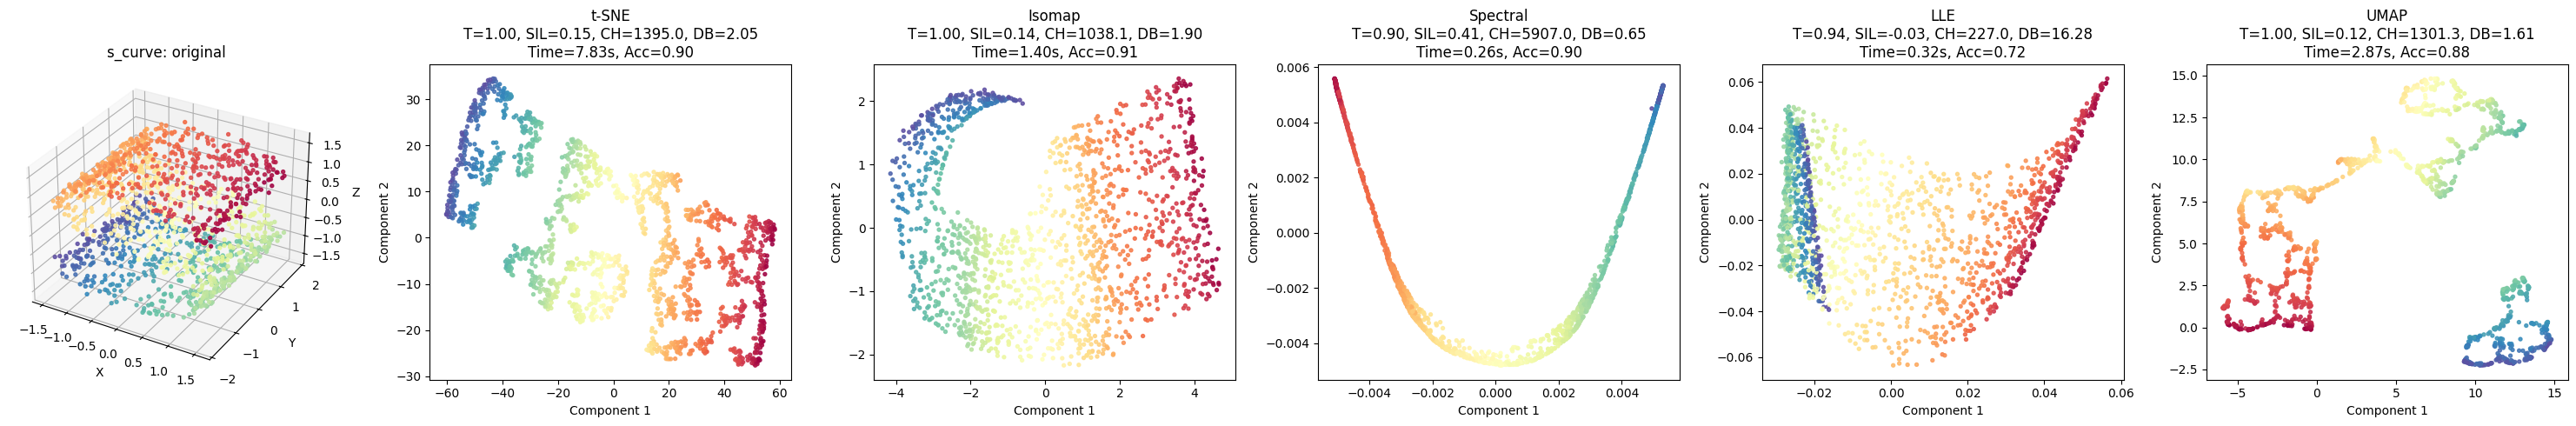

  t-SNE: metrics={'trustworthiness': 0.9993121492514857, 'silhouette': 0.14786297082901, 'calinski_harabasz': 1395.019287109375, 'davies_bouldin': 2.045557523746168, 'runtime_sec': 7.832745588999984, 'accuracy': 0.8977777777777778}
  Isomap: metrics={'trustworthiness': 0.9975714135259159, 'silhouette': 0.14364663589608964, 'calinski_harabasz': 1038.1117032897996, 'davies_bouldin': 1.9041717172757804, 'runtime_sec': 1.3982039530000065, 'accuracy': 0.9111111111111111}
  Spectral: metrics={'trustworthiness': 0.8992058376589183, 'silhouette': 0.41061353952249424, 'calinski_harabasz': 5906.971866335604, 'davies_bouldin': 0.6501094576090184, 'runtime_sec': 0.25765632499999924, 'accuracy': 0.9044444444444445}
  LLE: metrics={'trustworthiness': 0.9366410592040924, 'silhouette': -0.033097539996807895, 'calinski_harabasz': 226.9648101208792, 'davies_bouldin': 16.284787617088035, 'runtime_sec': 0.3218938520000165, 'accuracy': 0.7244444444444444}
  UMAP: metrics={'trustworthiness': 0.9985563830587

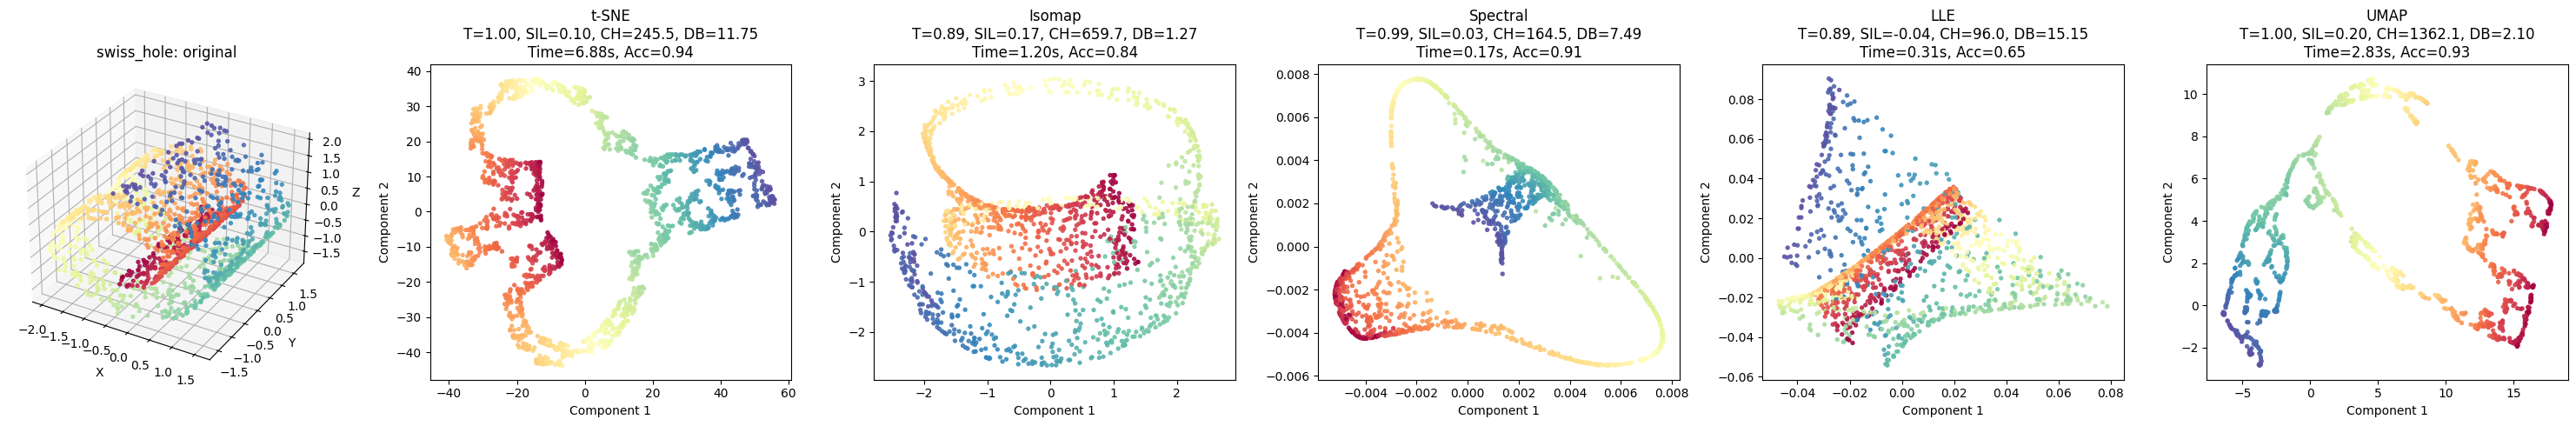

  t-SNE: metrics={'trustworthiness': 0.999377206048296, 'silhouette': 0.09961004555225372, 'calinski_harabasz': 245.45716857910156, 'davies_bouldin': 11.75326688519508, 'runtime_sec': 6.875500467000023, 'accuracy': 0.9355555555555556}
  Isomap: metrics={'trustworthiness': 0.8944849469645678, 'silhouette': 0.17266705321233997, 'calinski_harabasz': 659.7260540115419, 'davies_bouldin': 1.2741757749292004, 'runtime_sec': 1.203417571000017, 'accuracy': 0.8444444444444444}
  Spectral: metrics={'trustworthiness': 0.9868506431956668, 'silhouette': 0.02990468842764317, 'calinski_harabasz': 164.5336399485747, 'davies_bouldin': 7.485140043713254, 'runtime_sec': 0.16935331300001621, 'accuracy': 0.9111111111111111}
  LLE: metrics={'trustworthiness': 0.8862355224554277, 'silhouette': -0.03552687661993571, 'calinski_harabasz': 96.02758687003266, 'davies_bouldin': 15.154587988284865, 'runtime_sec': 0.31078426499999523, 'accuracy': 0.6533333333333333}
  UMAP: metrics={'trustworthiness': 0.9986927254946

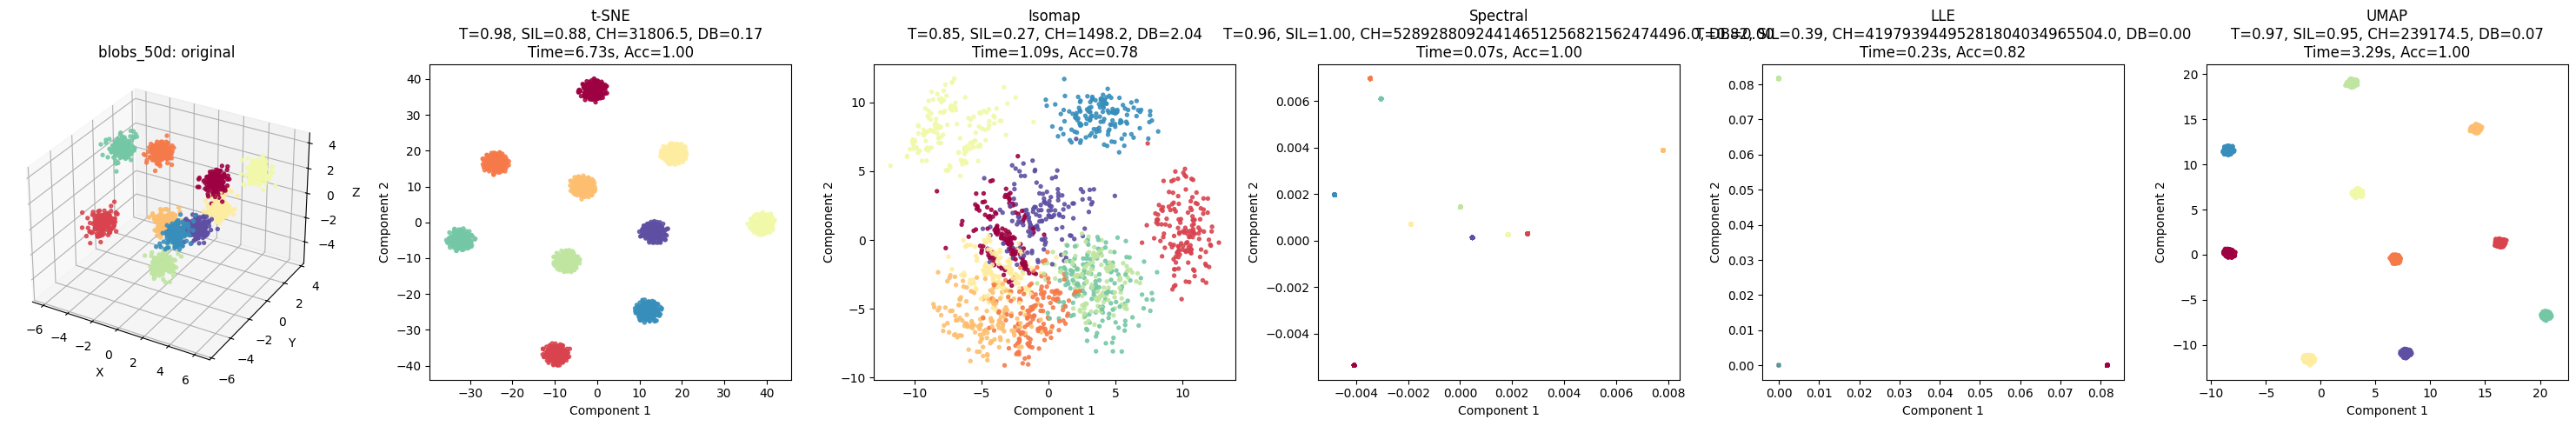

  t-SNE: metrics={'trustworthiness': 0.9778429549386896, 'silhouette': 0.881883442401886, 'calinski_harabasz': 31806.5234375, 'davies_bouldin': 0.16645168886244013, 'runtime_sec': 6.732931564000012, 'accuracy': 1.0}
  Isomap: metrics={'trustworthiness': 0.8513620100804935, 'silhouette': 0.2710339350171398, 'calinski_harabasz': 1498.2147786747516, 'davies_bouldin': 2.036504745005014, 'runtime_sec': 1.0898067539999943, 'accuracy': 0.7777777777777778}
  Spectral: metrics={'trustworthiness': 0.9612052057473859, 'silhouette': 0.999999990303784, 'calinski_harabasz': 5.289288092441465e+31, 'davies_bouldin': 0.0, 'runtime_sec': 0.07437323600001378, 'accuracy': 1.0}
  LLE: metrics={'trustworthiness': 0.8180135409614082, 'silhouette': 0.39173714595261605, 'calinski_harabasz': 4.19793944952818e+25, 'davies_bouldin': 0.0, 'runtime_sec': 0.23257031700001107, 'accuracy': 0.82}
  UMAP: metrics={'trustworthiness': 0.9692522079289851, 'silhouette': 0.9525765180587769, 'calinski_harabasz': 239174.515625

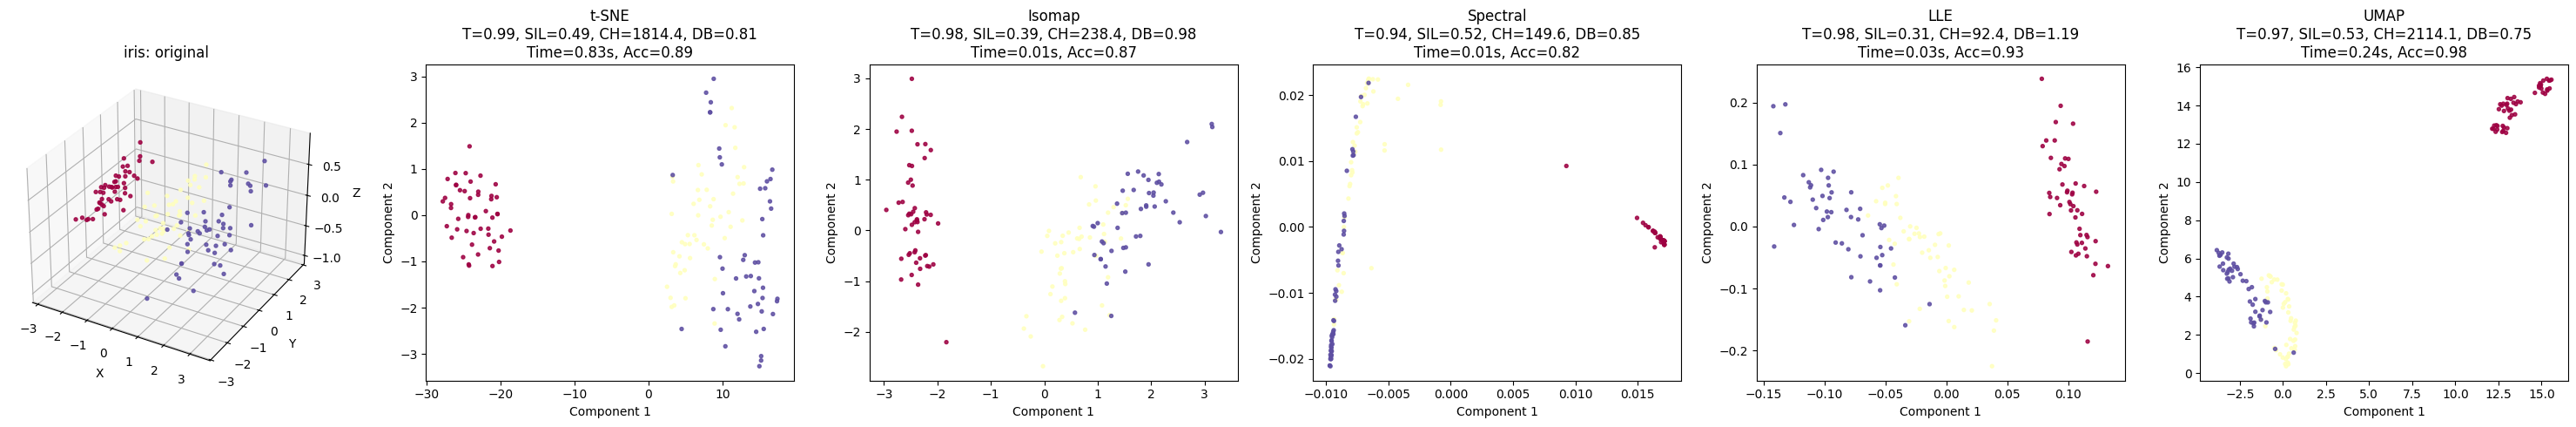

  t-SNE: metrics={'trustworthiness': 0.9852003499562555, 'silhouette': 0.49395695328712463, 'calinski_harabasz': 1814.417724609375, 'davies_bouldin': 0.8087433784363954, 'runtime_sec': 0.8264512890000049, 'accuracy': 0.8888888888888888}
  Isomap: metrics={'trustworthiness': 0.9808678915135608, 'silhouette': 0.38711036590036285, 'calinski_harabasz': 238.4495055709059, 'davies_bouldin': 0.9762439208928376, 'runtime_sec': 0.012938371999979381, 'accuracy': 0.8666666666666667}
  Spectral: metrics={'trustworthiness': 0.9388591426071741, 'silhouette': 0.5198546784982905, 'calinski_harabasz': 149.57145968159426, 'davies_bouldin': 0.8524202698837282, 'runtime_sec': 0.007727681999995184, 'accuracy': 0.8222222222222222}
  LLE: metrics={'trustworthiness': 0.9754575678040245, 'silhouette': 0.3145891857251039, 'calinski_harabasz': 92.35338020692843, 'davies_bouldin': 1.1906978697210222, 'runtime_sec': 0.025615754999989804, 'accuracy': 0.9333333333333333}
  UMAP: metrics={'trustworthiness': 0.9727734

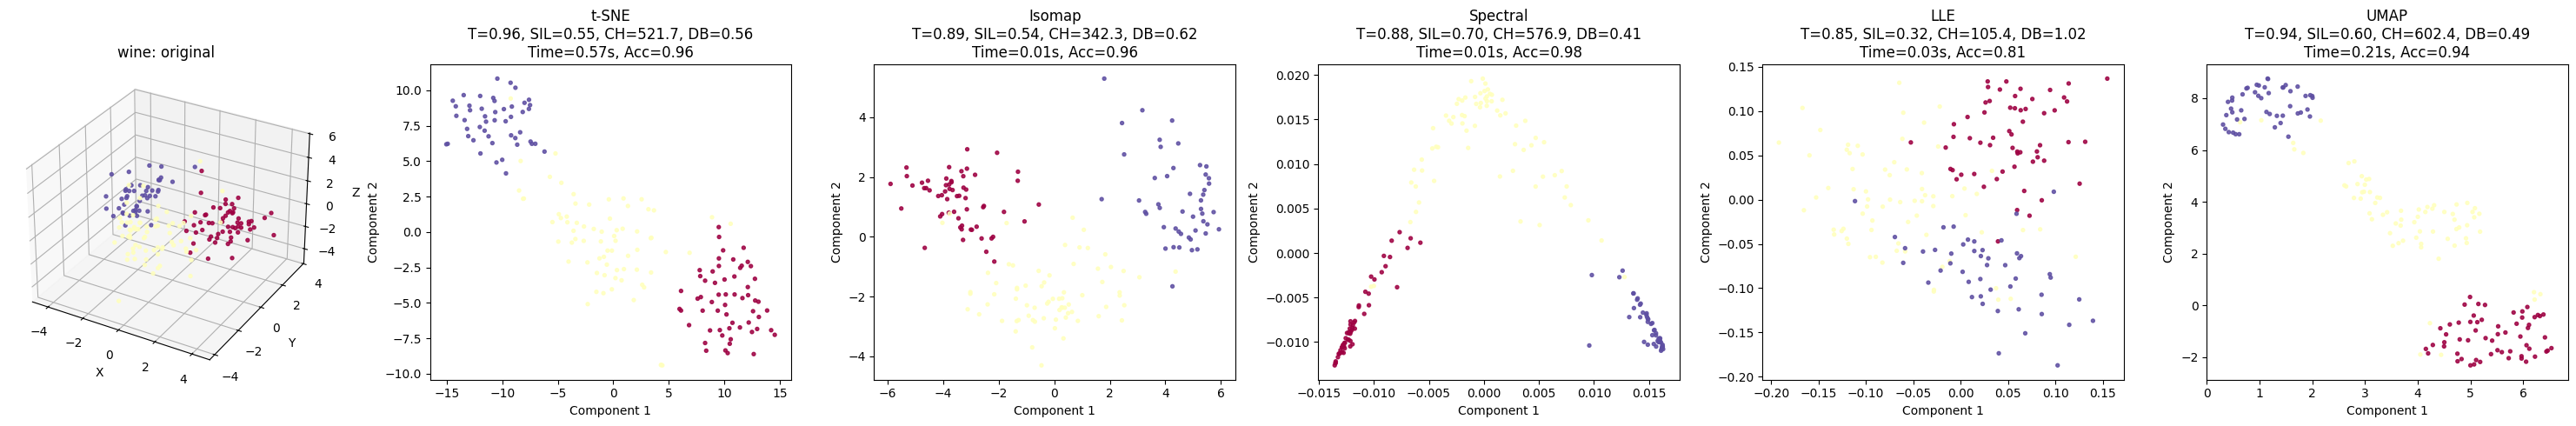

  t-SNE: metrics={'trustworthiness': 0.9591639482904434, 'silhouette': 0.55203777551651, 'calinski_harabasz': 521.6983642578125, 'davies_bouldin': 0.5643947451832628, 'runtime_sec': 0.5709646070000076, 'accuracy': 0.9629629629629629}
  Isomap: metrics={'trustworthiness': 0.894597076235351, 'silhouette': 0.53569271763711, 'calinski_harabasz': 342.332009861197, 'davies_bouldin': 0.6171293049893899, 'runtime_sec': 0.012390632999995432, 'accuracy': 0.9629629629629629}
  Spectral: metrics={'trustworthiness': 0.876766944545125, 'silhouette': 0.7036503796747824, 'calinski_harabasz': 576.9093537014405, 'davies_bouldin': 0.40882225143904355, 'runtime_sec': 0.010777421999989656, 'accuracy': 0.9814814814814815}
  LLE: metrics={'trustworthiness': 0.8463791228706052, 'silhouette': 0.31806157794107326, 'calinski_harabasz': 105.43478210045994, 'davies_bouldin': 1.0207288842765194, 'runtime_sec': 0.02955149599998208, 'accuracy': 0.8148148148148148}
  UMAP: metrics={'trustworthiness': 0.941575450042285

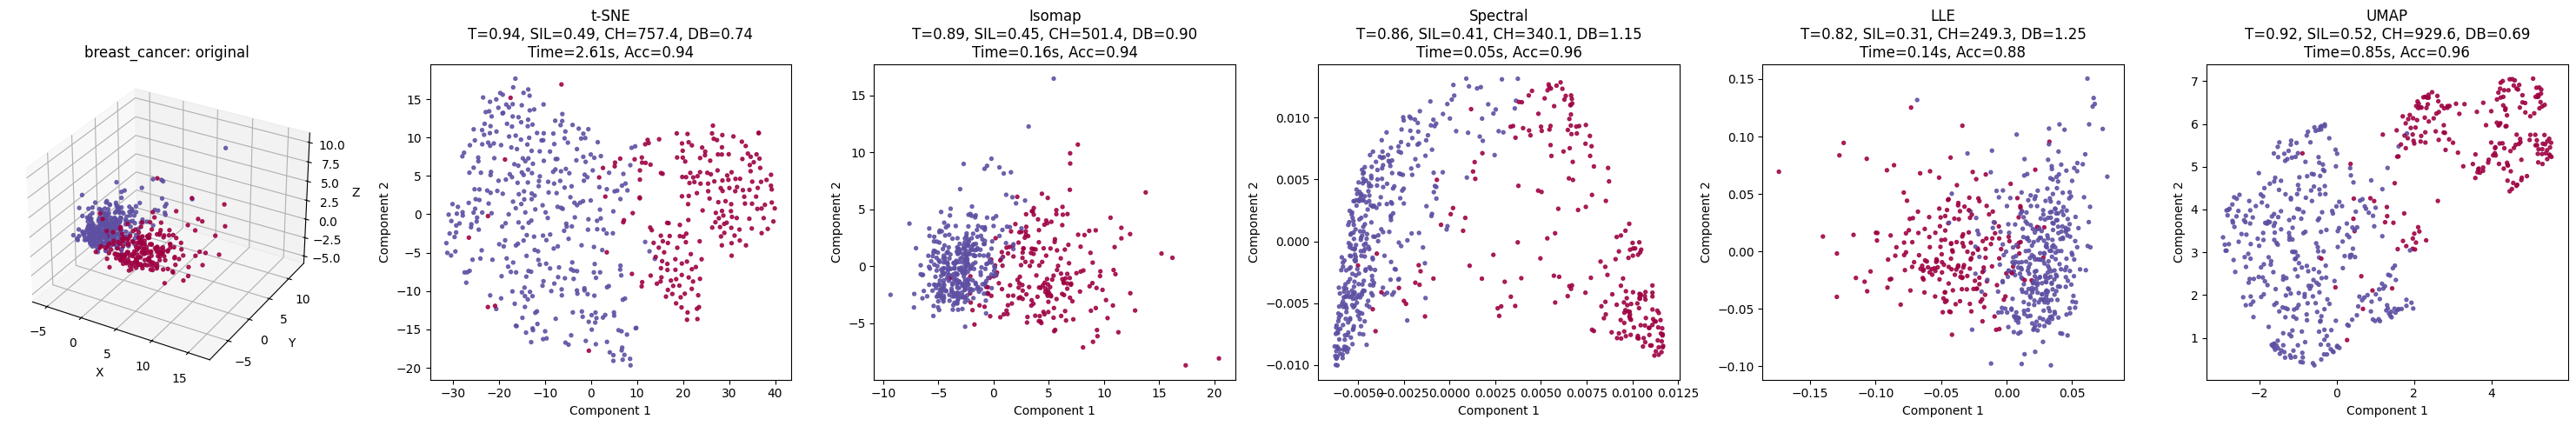

  t-SNE: metrics={'trustworthiness': 0.9383381508161824, 'silhouette': 0.48835527896881104, 'calinski_harabasz': 757.3756713867188, 'davies_bouldin': 0.7350314539284782, 'runtime_sec': 2.6099499660000163, 'accuracy': 0.935672514619883}
  Isomap: metrics={'trustworthiness': 0.8859245811794142, 'silhouette': 0.45022709907353076, 'calinski_harabasz': 501.40011364991153, 'davies_bouldin': 0.9011168475294389, 'runtime_sec': 0.15981272300001592, 'accuracy': 0.935672514619883}
  Spectral: metrics={'trustworthiness': 0.8551559941718114, 'silhouette': 0.40849959465819136, 'calinski_harabasz': 340.0901137942701, 'davies_bouldin': 1.1501130284874568, 'runtime_sec': 0.054987930999999435, 'accuracy': 0.9590643274853801}
  LLE: metrics={'trustworthiness': 0.8223121342629252, 'silhouette': 0.31008461233881884, 'calinski_harabasz': 249.28752138673616, 'davies_bouldin': 1.2472719199849038, 'runtime_sec': 0.1439217200000087, 'accuracy': 0.8830409356725146}
  UMAP: metrics={'trustworthiness': 0.919999527

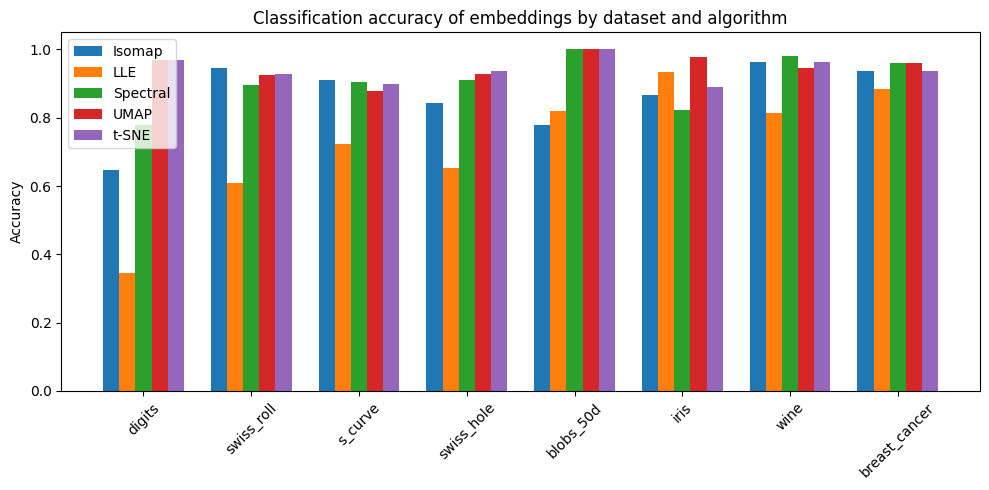


=== Efficiency Comparison (Mean ± Std. across datasets)===
t-SNE: 6.62 ± 5.78 seconds
Isomap: 0.90 ± 0.72 seconds
Spectral: 0.15 ± 0.13 seconds
LLE: 0.27 ± 0.21 seconds
UMAP: 2.83 ± 2.74 seconds

Analysis complete.  All figures saved in 'results/figures/'.


In [ ]:
# (Cell 3) Run experiments on synthetic + real-world datasets, plot results, and compare efficiency.
ensure_dir("results/figures")

# ORIGINAL: Define datasets
datasets = {}
digits = load_digits()
datasets["digits"] = (
    StandardScaler().fit_transform(digits.data.astype(float)),
    digits.target,
)
X_sr, y_sr = make_swiss_roll(n_samples=1500, noise=0.05, random_state=0)
datasets["swiss_roll"] = (StandardScaler().fit_transform(X_sr), y_sr)
X_sc, y_sc = make_s_curve(n_samples=1500, noise=0.05, random_state=0)
datasets["s_curve"] = (StandardScaler().fit_transform(X_sc), y_sc)
X_sh, y_sh = make_swiss_roll(n_samples=1500, hole=True, random_state=0)
datasets["swiss_hole"] = (StandardScaler().fit_transform(X_sh), y_sh)
X_b, y_b = make_blobs(
    n_samples=1500, n_features=50, centers=10, cluster_std=2.5, random_state=0
)
datasets["blobs_50d"] = (StandardScaler().fit_transform(X_b), y_b)
iris = load_iris()
datasets["iris"] = (
    StandardScaler().fit_transform(iris.data.astype(float)),
    iris.target,
)
wine = load_wine()
datasets["wine"] = (
    StandardScaler().fit_transform(wine.data.astype(float)),
    wine.target,
)
bc = load_breast_cancer()
datasets["breast_cancer"] = (
    StandardScaler().fit_transform(bc.data.astype(float)),
    bc.target,
)

accuracy_table = {}
runtime_summary = {}

for name, (X, y) in datasets.items():
    print(f"\n=== Dataset: {name} | n={X.shape[0]}, d={X.shape[1]} ===")
    embeddings, metrics_dict = run_embedding_methods(X, y)
    fig = plot_dataset_and_embeddings(X, y, embeddings, metrics_dict, name)
    fig.savefig(f"results/figures/{name}_comparison.png", dpi=150)
    plt.show()

    accuracy_table[name] = {}
    for method, metrics in metrics_dict.items():
        accuracy_table[name][method] = metrics["accuracy"]
        runtime_summary.setdefault(method, []).append(metrics["runtime_sec"])
        print(f"  {method}: metrics={metrics}")

acc_fig = plot_accuracy_bar(accuracy_table)
acc_fig.savefig("results/figures/accuracy_comparison.png", dpi=150)
plt.show()

print("\n=== Efficiency Comparison (Mean ± Std. across datasets)===")
for method, times in runtime_summary.items():
    mean_time = np.mean(times)
    std_time = np.std(times)
    print(f"{method}: {mean_time:.2f} ± {std_time:.2f} seconds")

print("\nAnalysis complete.  All figures saved in 'results/figures/'.")